In [1]:
import pandas as pd
from prophet import Prophet
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt

In [2]:
# Load the data
df_test = pd.read_csv("kartoum2017test.csv")
df_train = pd.read_csv("kartoum2017train.csv")
df = df_train


In [3]:
# Display train and test data
print(df_train.head())


         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000


In [4]:
print(df_test.head())

         date   meantemp   humidity  wind_speed  meanpressure  Unnamed: 5  \
0  01/01/2017  15.913043  85.869565    2.743478     59.000000         NaN   
1  02/01/2017  18.500000  77.222222    2.894444   1018.277778         NaN   
2  03/01/2017  17.111111  81.888889    4.016667   1018.333333         NaN   
3  04/01/2017  18.700000  70.050000    4.545000   1015.700000         NaN   
4  05/01/2017  18.388889  74.944444    3.300000   1014.333333         NaN   

   Unnamed: 6  Unnamed: 7 Unnamed: 8  
0         NaN         NaN        NaN  
1         NaN         NaN        NaN  
2         NaN         NaN        NaN  
3         NaN         NaN        NaN  
4         NaN         NaN        NaN  


In [5]:
# Univariate Forecasting
# Rename columns for Prophet
df_train = df_train.rename(columns={'meantemp': 'y', 'date': 'ds'})
df_train['y_orig'] = df_train['y']  # Save a copy of the original data
df_train['y'] = np.log(df_train['y'])  # Log transform the target variable


In [6]:
# Fit the Prophet model
model = Prophet()
model.fit(df_train)


16:45:12 - cmdstanpy - INFO - Chain [1] start processing
16:45:13 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# Make future predictions
future_data = model.make_future_dataframe(periods=113, freq='D')
forecast_data = model.predict(future_data)

In [8]:
# Extract and display forecasted data
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1570,2017-04-20,3.551835,3.429911,3.682624
1571,2017-04-21,3.555606,3.438412,3.671934
1572,2017-04-22,3.555885,3.424393,3.687528
1573,2017-04-23,3.555255,3.434721,3.685969
1574,2017-04-24,3.572521,3.448077,3.692667


In [9]:
# Inverse transform of the forecast data
forecast_data_orig = forecast_data.copy()
forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])


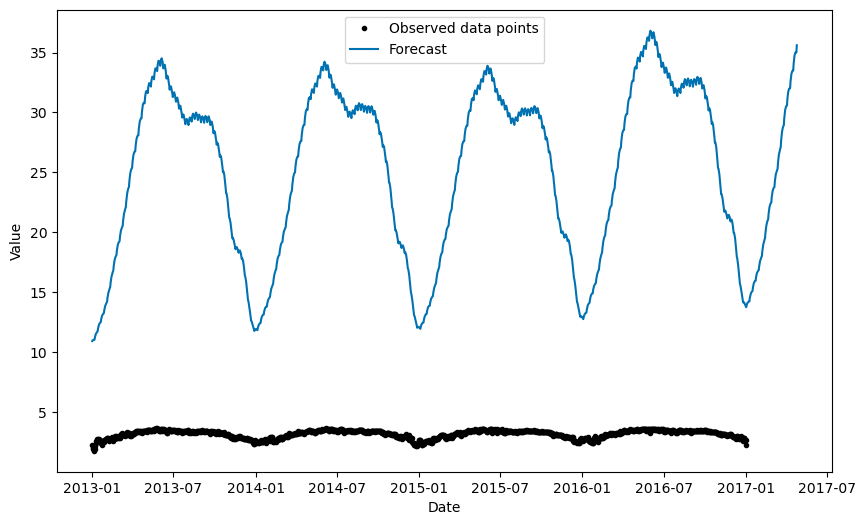

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to numpy arrays
ds_values = np.array(forecast_data_orig['ds'])
y_values = np.array(forecast_data_orig['yhat'])

# Plot the forecast
fig, ax = plt.subplots(figsize=(10, 6))

# Plot observed data points
ax.plot(np.array(model.history['ds']), np.array(model.history['y']), 'k.', label='Observed data points')

# Plot forecast
ax.plot(ds_values, y_values, ls='-', c='#0072B2', label='Forecast')

# Additional settings
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()

plt.show()


In [11]:
# Plotly plot
df_train['y_log'] = df_train['y']  # Copy the log-transformed data
df_train['y'] = df_train['y_orig']  # Revert 'y' to original data

final_df = pd.DataFrame(forecast_data_orig)

In [12]:
# Plot predicted and actual line graph with X=dates, Y=Outbound
actual_chart = go.Scatter(y=df_train["y_orig"], name='Actual')
predict_chart = go.Scatter(y=final_df["yhat"], name='Predicted')
predict_chart_upper = go.Scatter(y=final_df["yhat_upper"], name='Predicted Upper')
predict_chart_lower = go.Scatter(y=final_df["yhat_lower"], name='Predicted Lower')

py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower], filename='temp-plot.html')


'temp-plot.html'

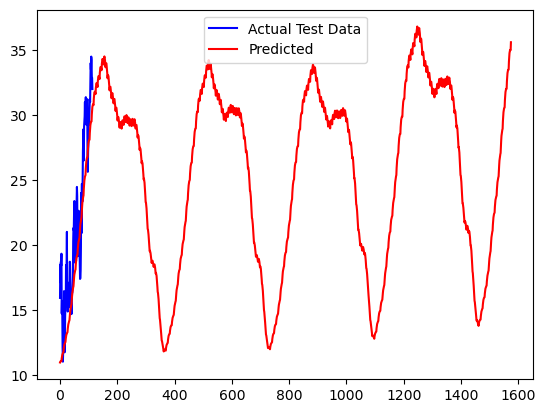

In [13]:
# Plot matplotlib
plt.plot(df_test['meantemp'], color='blue', label='Actual Test Data')
plt.plot(final_df['yhat'], color='red', label='Predicted')
plt.legend()
plt.show()

In [27]:
# Multi-Variate Forecasting

df_test = pd.read_csv("kartoum2017test.csv")
df_train = pd.read_csv("kartoum2017train.csv")
df = df_train


In [28]:
# Rename columns for Prophet
df_train = df_train.rename(columns={'meantemp': 'y', 'date': 'ds'})
df_train['y_orig'] = df_train['y']
df_train['y'] = np.log(df_train['y'])



In [29]:
# Add regressors
model_new = Prophet()
model_new.add_regressor('humidity')
model_new.add_regressor('wind_speed')
model_new.add_regressor('meanpressure')

In [30]:
import pandas as pd

# Concatenate DataFrames using pd.concat()
df = pd.concat([df, df_test], ignore_index=True)

# Proceed with renaming columns
df = df.rename(columns={'meantemp': 'y', 'date': 'ds'})

# Select relevant columns for future data
future_data = df[['ds', 'humidity', 'wind_speed', 'meanpressure']]


In [34]:
import pandas as pd

# Convert 'ds' column to datetime with automatic format detection
future_data['ds'] = pd.to_datetime(future_data['ds'], errors='coerce')

# Check for any NaT values that could indicate parsing issues
print(future_data[future_data['ds'].isna()])

# Make future predictions if there are no parsing issues
if future_data['ds'].notna().all():
    forecast_data = model_new.predict(future_data)
    print(forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5))
else:
    
    print("There are issues with some dates in 'ds'.")


      ds   humidity  wind_speed  meanpressure
1462 NaT  85.869565    2.743478     59.000000
1463 NaT  77.222222    2.894444   1018.277778
1464 NaT  81.888889    4.016667   1018.333333
1465 NaT  70.050000    4.545000   1015.700000
1466 NaT  74.944444    3.300000   1014.333333
...   ..        ...         ...           ...
1571 NaT  27.500000    5.562500    998.625000
1572 NaT  39.375000    6.962500    999.875000
1573 NaT  40.900000    8.890000   1001.600000
1574 NaT  27.500000    9.962500   1002.125000
1575 NaT  27.142857   12.157143   1004.142857

[114 rows x 4 columns]
There are issues with some dates in 'ds'.


C:\Users\Skynet\AppData\Local\Temp\ipykernel_15476\2146604940.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



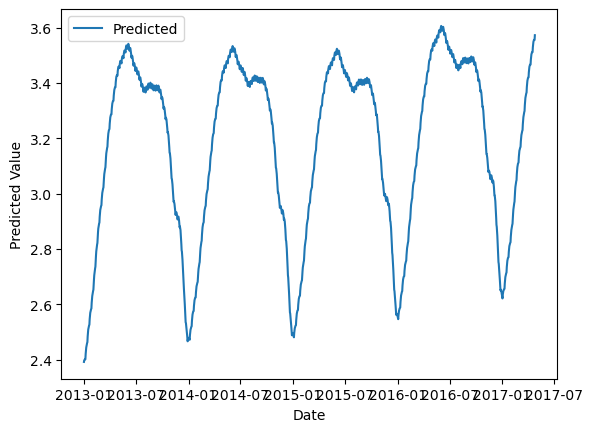

In [32]:
import matplotlib.pyplot as plt

# Convert to numpy arrays
ds_array = forecast_data['ds'].to_numpy()
yhat_array = forecast_data['yhat'].to_numpy()

# Plot future data
plt.plot(ds_array, yhat_array, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()
